In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys

curr_path = !pwd
curr_path = curr_path[0] + "/"
curr_path

'/content/'

In [ ]:
utils_path = os.path.join(os.path.dirname(curr_path), 'drive', 'MyDrive', 'cmpt420_project', 'src', 'utils/')
utils_path

'/content/drive/MyDrive/cmpt420_project/src/utils/'

In [ ]:
sys.path.append(utils_path)

In [ ]:
img_path = os.path.join(os.path.dirname(curr_path), 'drive', 'MyDrive', 'CelebA', 'Img', 'img_align_celeba.zip')
img_path

'/content/drive/MyDrive/CelebA/Img/img_align_celeba.zip'

In [ ]:
data_path = os.path.join('/tmp', 'dataset/')
data_path

'/tmp/dataset/'

### Unzipping dataset

In [ ]:
if (os.path.exists(data_path)) == False:
  !mkdir {data_path}

In [ ]:
# import zipfile

if os.path.exists(os.path.join(os.path.dirname(data_path), 'img_align_celeba')) == False:
  !unzip {img_path} -d {data_path}


Streaming output truncated to the last 5000 lines.
 extracting: /tmp/dataset/img_align_celeba/197600.jpg  
 extracting: /tmp/dataset/img_align_celeba/197601.jpg  
 extracting: /tmp/dataset/img_align_celeba/197602.jpg  
 extracting: /tmp/dataset/img_align_celeba/197603.jpg  
 extracting: /tmp/dataset/img_align_celeba/197604.jpg  
 extracting: /tmp/dataset/img_align_celeba/197605.jpg  
 extracting: /tmp/dataset/img_align_celeba/197606.jpg  
 extracting: /tmp/dataset/img_align_celeba/197607.jpg  
 extracting: /tmp/dataset/img_align_celeba/197608.jpg  
 extracting: /tmp/dataset/img_align_celeba/197609.jpg  
 extracting: /tmp/dataset/img_align_celeba/197610.jpg  
 extracting: /tmp/dataset/img_align_celeba/197611.jpg  
 extracting: /tmp/dataset/img_align_celeba/197612.jpg  
 extracting: /tmp/dataset/img_align_celeba/197613.jpg  
 extracting: /tmp/dataset/img_align_celeba/197614.jpg  
 extracting: /tmp/dataset/img_align_celeba/197615.jpg  
 extracting: /tmp/dataset/img_align_celeba/197616.jpg

In [ ]:
data_path

'/tmp/dataset/'

### Importing Dependencies

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from DataLoader import CelebADataset
from PruningHelper import PruningHelper as ph
from torch.nn.utils.prune import global_unstructured, L1Unstructured
from torch.utils.data import random_split, DataLoader, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Hyperparameters

In [ ]:
SAMPLE_SEED = 42
K_FOLDS = 4
EPOCHS = 5

BATCH_SIZE = 256

In [ ]:
# att_path = f"../../../dataset/Anno/list_attr_celeba.txt"
att_path = os.path.join(os.path.dirname(curr_path), 'drive', 'MyDrive', 'cmpt420_project', 'dataset', 'Anno', 'list_attr_celeba.txt')

dataset = CelebADataset(os.path.join(os.path.dirname(data_path), 'img_align_celeba'), att_path)

In [ ]:
TOTAL_SIZE = len(dataset)
TOTAL_SIZE

202599

#### Dataset split:

In [ ]:
# SAMPLE_SIZE = 1000

In [ ]:
test_size = int(0.1 * TOTAL_SIZE)
train_size = TOTAL_SIZE - test_size

# Generator
generator = torch.Generator().manual_seed(SAMPLE_SEED)

# Data Sampling
# sample_indices = torch.randperm(len(dataset))[:SAMPLE_SIZE]
# ds_sample = Subset(dataset, sample_indices)
# ds_train, ds_test = random_split(ds_sample, [train_size, test_size], generator=generator)
# print(f"[Sampling] Train size: {len(ds_train)}, Test size: {len}")
# -----------End sampling ---------------

# TODO: USE THIS FOR FULL TRAINING
# Data split
indices = torch.randperm(len(dataset))
ds_train, ds_test = random_split(dataset, [train_size, test_size], generator=generator)

print(f"Train size: {len(ds_train)}, Test size: {len(ds_test)}")

Train size: 182340, Test size: 20259


In [ ]:
train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=False)

### Pruning settings


In [ ]:
# With Sampling
PRUNE_START_STEP = 1000
PRUNE_ITER_STEP = 500

In [ ]:
total_steps = ph.get_total_steps(len(ds_train), BATCH_SIZE, K_FOLDS, EPOCHS)
total_steps

10700

In [ ]:
pruning_schedule = ph.get_pruning_schedule(total_steps, pruning_start=PRUNE_START_STEP, pruning_interval=PRUNE_ITER_STEP)
pruning_rate = ph.get_pruning_rate(pruning_schedule, 0.9)
pruning_schedule, pruning_rate

([1000,
  1500,
  2000,
  2500,
  3000,
  3500,
  4000,
  4500,
  5000,
  5500,
  6000,
  6500,
  7000,
  7500,
  8000,
  8500,
  9000,
  9500,
  10000,
  10500],
 0.108749)

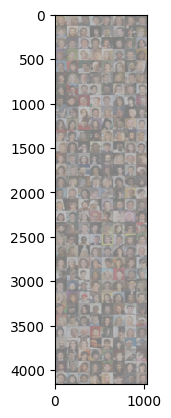

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 4 + 0.5
    npimg  =img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

# get random training img
dataiter = iter(train_loader)
images, labels, _ = next(dataiter)

# show img
imshow(torchvision.utils.make_grid(images))

In [ ]:
def trainer(model, optimizer, pruning=False):
    criterion = nn.BCEWithLogitsLoss()

    kf = KFold(n_splits=K_FOLDS, shuffle=True)

    total_loss = []
    total_accuracy = []
    total_precision = []
    total_recall = []
    total_f1_score = []

    # Training
    step = 0
    num_of_prunes = 0
    for fold, (train_k, val_k) in enumerate(kf.split(ds_train)):

        train_loader_k = DataLoader(dataset=ds_train, batch_size=BATCH_SIZE, sampler=torch.utils.data.SubsetRandomSampler(train_k))

        val_loader_k = DataLoader(
            dataset=ds_train,
            batch_size=BATCH_SIZE,
            sampler=torch.utils.data.SubsetRandomSampler(val_k)
        )

        model.train()
        for epoch in range(EPOCHS):
            epoch_loss = 0
            for imgs, lbls, _ in train_loader_k:
                imgs, lbls = imgs.to(device), lbls.to(device).float()

                outputs = model(imgs).squeeze(1)
                loss = criterion(outputs, lbls)
                epoch_loss += loss.item()

                optimizer.zero_grad()
                loss.backward()

                # Add step
                step+=1

                # Pruning
                if pruning and (step in pruning_schedule):
                    num_of_prunes += 1
                    global_unstructured(
                        [(m, 'weight') for m in model.modules() if isinstance(m, (nn.Conv2d, nn.Linear))],
                        pruning_method=L1Unstructured,
                        amount=pruning_rate,
                    )
                    print(f"[Step {step}]Num of prunes -> {num_of_prunes}\nTotal sparsity: {ph.get_sparsity(model)}")


                optimizer.step()

            avg_epoch_loss = epoch_loss / len(train_loader_k)
            total_loss.append(avg_epoch_loss)
            print(f"Fold: {fold+1}, Epoch: [{epoch + 1}/{EPOCHS}], Loss: {avg_epoch_loss:.7f}")

        # Evaluation of model
        model.eval()
        total=0
        correct=0
        y_pred = []
        y_true = []

        with torch.no_grad():
            for imgs, lbls, _ in val_loader_k:
                imgs, lbls = imgs.to(device), lbls.to(device).float()
                outputs = model(imgs).squeeze(1)
                predicted = (torch.sigmoid(outputs) > 0.5).float()

                y_true.extend(lbls.cpu().numpy()) #storing true values
                y_pred.extend(predicted.cpu().numpy()) #storing predictions
                total += lbls.size(0)
                correct += (predicted == lbls).sum().item()


        accuracy = correct / total
        precision = precision_score(y_true, y_pred, average='binary', zero_division=0)
        recall = recall_score(y_true, y_pred, average='binary', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)

        total_accuracy.append(accuracy)
        total_precision.append(precision)
        total_recall.append(recall)
        total_f1_score.append(f1)

        print(f"Fold: [{fold + 1}/{K_FOLDS}], Accuracy: {accuracy}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

    print(f"Avg. accuracy: {np.mean(total_accuracy):.2f}")
    print(f"Avg. precision: {np.mean(total_precision):.2f}")
    print(f"Avg. Recall: {np.mean(total_recall):.2f}")
    print(f"Avg. F1-score: {np.mean(total_f1_score):.2f}")

    print("Training Completed")
    print(f"Number of steps {step}")

    return model, total_loss, total_accuracy, total_precision, total_recall, total_f1_score

In [ ]:
def test_model(model, test_loader):
    print("Test Evaluation")

    model.eval()
    y_pred_test = []
    y_true_test = []
    total_samples = 0
    correct_predictions = 0

    with torch.no_grad():
        for imgs, lbls, _ in test_loader:
            imgs, lbls = imgs.to(device), lbls.to(device).float()
            outputs = model(imgs).squeeze(1)
            predicted = (torch.sigmoid(outputs) > 0.5).float()

            y_true_test.extend(lbls.cpu().numpy())
            y_pred_test.extend(predicted.cpu().numpy())

            total_samples += lbls.size(0)
            correct_predictions += (predicted == lbls).sum().item()

    accuracy = correct_predictions / total_samples
    precision_test = precision_score(y_true_test, y_pred_test, average='binary', zero_division=0)
    recall_test = recall_score(y_true_test, y_pred_test, average='binary', zero_division=0)
    f1_score_test = f1_score(y_true_test, y_pred_test, average='binary',zero_division=0)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Test precision: {precision_test:.2f}")
    print(f"Test recall: {recall_test:.2f}")
    print(f"Test f1-score: {f1_score_test:.2f}")

    print("Finished test evaluation!")

In [ ]:
def plot_loss_curves(train_losses):
    if K_FOLDS != 4:
        return

    fig, axes = plt.subplots(1,4, figsize=(10,3))
    axes = axes.ravel()
    total_losses = len(train_losses)
    losses_per_fold = total_losses / K_FOLDS #Losses included per graph

    for graph in range(K_FOLDS):
        start_loss = int(graph * losses_per_fold)
        end_loss = int(start_loss + losses_per_fold)
        losses = np.array(train_losses[start_loss:end_loss])
        epochs = np.arange(1, EPOCHS + 1)

        axes[graph].plot(epochs, losses, linewidth=2)
        axes[graph].set_title(f'Fold {graph+1}', fontsize=12)
        axes[graph].set_xlabel('Epochs', fontsize=10)
        axes[graph].set_ylabel('Loss', fontsize=10)
        axes[graph].grid(True, linestyle='--', alpha=0.5)

        # Setting y-limits
        y_padding = 0.1 * (np.max(train_losses) - np.min(train_losses))
        axes[graph].set_ylim([np.min(train_losses) - y_padding,
                              np.max(train_losses) + y_padding])

    plt.suptitle(f"{K_FOLDS} Cross Validation Loss Curves", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

### Initializing model

In [ ]:
from ResNet import ResNet, BasicBlock

def ResNet18(num_classes=1):
    resnet = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
    return resnet

model = ResNet18().to(device)

In [ ]:
resnet_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total # of params: {resnet_total_params}")

Total # of params: 11177025


##BaseLine Model (No Pruning)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [ ]:
np_trained_model, np_losses, np_total_accuracy, np_total_precision, np_total_recall, np_total_f1_score = trainer(model=model, optimizer=optimizer, pruning=False)

Fold: 1, Epoch: [1/5], Loss: 0.1616260
Fold: 1, Epoch: [2/5], Loss: 0.1271544
Fold: 1, Epoch: [3/5], Loss: 0.1201321
Fold: 1, Epoch: [4/5], Loss: 0.1158581
Fold: 1, Epoch: [5/5], Loss: 0.1111156
Fold: [1/4], Accuracy: 0.9489525063068992, Precision: 0.91, Recall: 0.73, F1-Score: 0.81
Fold: 2, Epoch: [1/5], Loss: 0.1105649
Fold: 2, Epoch: [2/5], Loss: 0.1072011
Fold: 2, Epoch: [3/5], Loss: 0.1021922
Fold: 2, Epoch: [4/5], Loss: 0.0981553
Fold: 2, Epoch: [5/5], Loss: 0.0919792
Fold: [2/4], Accuracy: 0.9550071295382253, Precision: 0.85, Recall: 0.85, F1-Score: 0.85
Fold: 3, Epoch: [1/5], Loss: 0.0947812
Fold: 3, Epoch: [2/5], Loss: 0.0865644
Fold: 3, Epoch: [3/5], Loss: 0.0760236
Fold: 3, Epoch: [4/5], Loss: 0.0633441
Fold: 3, Epoch: [5/5], Loss: 0.0495091
Fold: [3/4], Accuracy: 0.9573982669737853, Precision: 0.89, Recall: 0.81, F1-Score: 0.85
Fold: 4, Epoch: [1/5], Loss: 0.0640995
Fold: 4, Epoch: [2/5], Loss: 0.0437507
Fold: 4, Epoch: [3/5], Loss: 0.0322968
Fold: 4, Epoch: [4/5], Loss: 0.

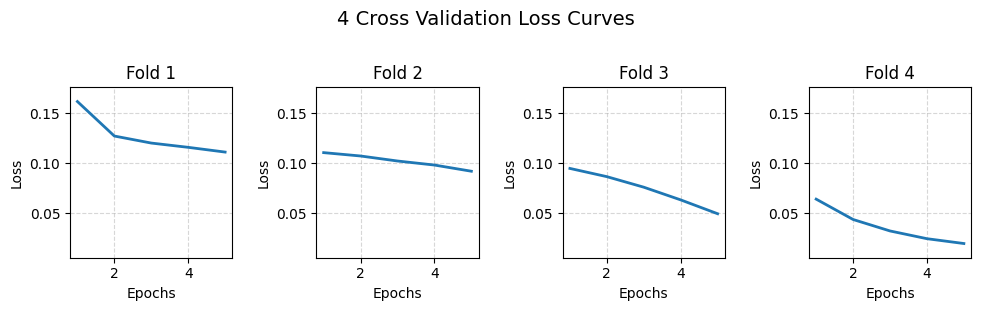

In [ ]:
plot_loss_curves(np_losses)

In [ ]:
ph.get_sparsity(np_trained_model) # Percentage of weights removed

0.0

In [ ]:
test_loader = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
test_model(model=model,test_loader=test_loader)

Test Evaluation
Accuracy: 0.95
Test precision: 0.85
Test recall: 0.80
Test f1-score: 0.83
Finished test evaluation!


### Saving non-pruned model weights

In [64]:
from datetime import datetime

current_time = datetime.now().strftime("%m_%d_%Y_%H_%M")
torch.save(np_trained_model, f'/content/drive/MyDrive/full_model_{current_time}.pth')

In [ ]:
loaded_model = torch.load('/content/drive/MyDrive/full_model.pth', weights_only=False)
test_model(loaded_model, test_loader)

## Pruned Model (90% Sparsity)

In [ ]:
p_model = ResNet18().to(device)

In [ ]:
p_optimizer = torch.optim.AdamW(p_model.parameters(), lr=0.001)

In [ ]:
p_trained_model, p_losses, p_total_accuracy, p_total_precision, p_total_recall, p_total_f1_score = trainer(model=p_model, optimizer=p_optimizer, pruning=True)

Fold: 1, Epoch: [1/5], Loss: 0.1675396
[Step 1000]Num of prunes -> 1
Total sparsity: 10.87489827555576
Fold: 1, Epoch: [2/5], Loss: 0.1292346
[Step 1500]Num of prunes -> 2
Total sparsity: 20.56716034064794
Fold: 1, Epoch: [3/5], Loss: 0.1208425
[Step 2000]Num of prunes -> 3
Total sparsity: 29.20540135307838
Fold: 1, Epoch: [4/5], Loss: 0.1150285
[Step 2500]Num of prunes -> 4
Total sparsity: 36.90424040494925
Fold: 1, Epoch: [5/5], Loss: 0.1105868
Fold: [1/4], Accuracy: 0.9530547329165295, Precision: 0.89, Recall: 0.78, F1-Score: 0.83
[Step 3000]Num of prunes -> 5
Total sparsity: 43.765840716713186
Fold: 2, Epoch: [1/5], Loss: 0.1093471
[Step 3500]Num of prunes -> 6
Total sparsity: 49.881252829658834
Fold: 2, Epoch: [2/5], Loss: 0.1037694
[Step 4000]Num of prunes -> 7
Total sparsity: 55.331614524531346
Fold: 2, Epoch: [3/5], Loss: 0.0978713
[Step 4500]Num of prunes -> 8
Total sparsity: 60.189261193987086
Fold: 2, Epoch: [4/5], Loss: 0.0915738
[Step 5000]Num of prunes -> 9
Total sparsity

In [65]:
torch.save(p_trained_model, f'/content/drive/MyDrive/pruned_model_{current_time}.pth')

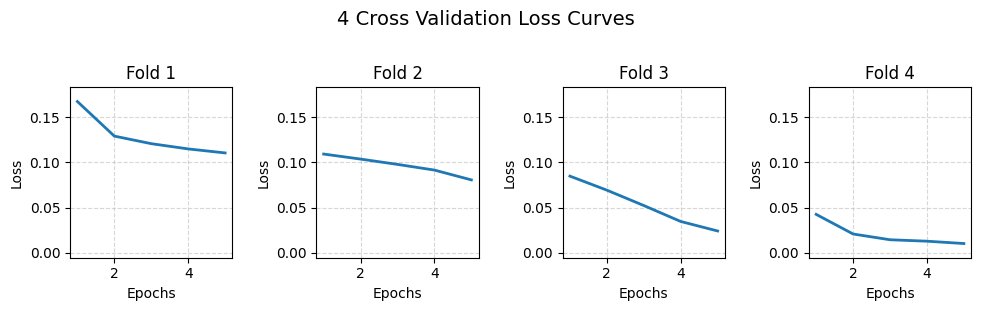

In [ ]:
plot_loss_curves(p_losses)

In [ ]:
ph.get_sparsity(p_trained_model) # Percentage of weights removed

89.99998567261349

In [ ]:
test_model(model=p_model,test_loader=test_loader)

Test Evaluation
Accuracy: 0.95
Test precision: 0.83
Test recall: 0.80
Test f1-score: 0.81
Finished test evaluation!


In [ ]:
p_loaded_model = torch.load(f'/content/drive/MyDrive/pruned_model_{current_time}.pth', weights_only=False)
test_model(p_loaded_model, test_loader)

Test Evaluation
Accuracy: 0.95
Test precision: 0.83
Test recall: 0.80
Test f1-score: 0.81
Finished test evaluation!


### Determining CIEs

In [ ]:
def get_cie_count(model_1, model_2, test_loader):
        print("Determining CIEs:")

        model_1.eval()
        model_2.eval()
        cie_list = []

        with torch.no_grad():
            for imgs, lbls, sample_name in test_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)

                outputs_1 = model_1(imgs).squeeze(1)
                predicted_1 = (torch.sigmoid(outputs_1) > 0.5).float()

                outputs_2 = model_2(imgs).squeeze(1)
                predicted_2 = (torch.sigmoid(outputs_2) > 0.5).float()

                disagree_mask = (predicted_1 != predicted_2)

                for i in range(len(sample_name)):
                     if disagree_mask[i]:
                          cie_list.append(sample_name[i])

        print(f"Number of CIEs: {len(cie_list)}")

        return cie_list

In [ ]:
train_cie_list = get_cie_count(np_trained_model, p_trained_model, test_loader)

Determining CIEs:
Number of CIEs: 760


In [67]:
training_cie_list = get_cie_count(np_trained_model, p_trained_model, train_loader)

Determining CIEs:
Number of CIEs: 2304


### Confirming models are loaded properly

In [68]:
model_1 = torch.load(f'/content/drive/MyDrive/full_model_04_07_2025_01_07.pth', weights_only=False)
model_2 = torch.load(f'/content/drive/MyDrive/pruned_model_04_07_2025_01_07.pth', weights_only=False)

In [72]:
test_model(model_1, test_loader)

Test Evaluation
Accuracy: 0.95
Test precision: 0.85
Test recall: 0.80
Test f1-score: 0.83
Finished test evaluation!


In [73]:
test_model(model_2, test_loader)

Test Evaluation
Accuracy: 0.95
Test precision: 0.83
Test recall: 0.80
Test f1-score: 0.81
Finished test evaluation!


In [74]:
test_cie_list = get_cie_count(model_1, model_2, test_loader)

Determining CIEs:
Number of CIEs: 760


In [76]:
train_cie_list = get_cie_count(model_1, model_2, train_loader)

Determining CIEs:
Number of CIEs: 2304


In [79]:
total_cie_count = len(test_cie_list) + len(train_cie_list)
print(f"Total CIE count: {total_cie_count}")

Total CIE count: 3064
